In [155]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rc('legend', fontsize=10)
matplotlib.rcParams['figure.dpi'] = 300

#### Illustration of wavelength solution

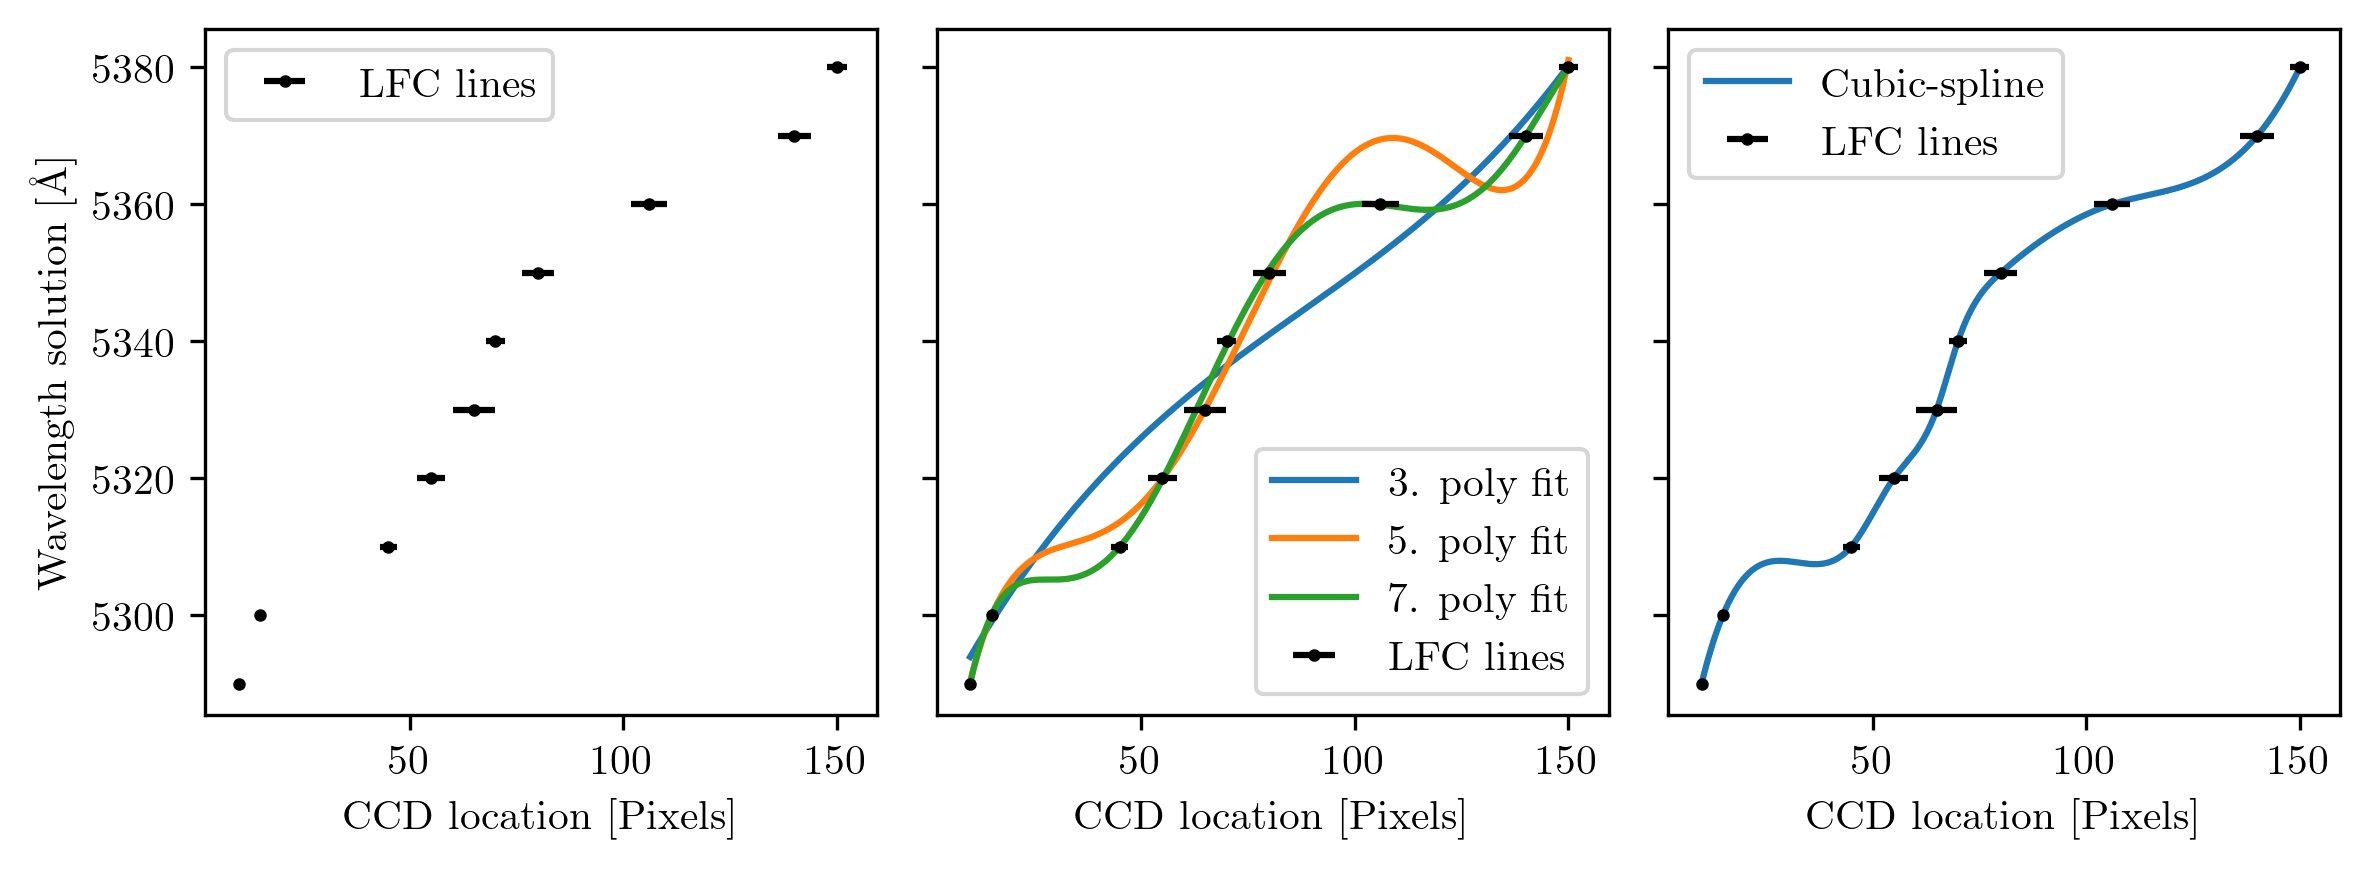

In [183]:
# Plot
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8,3), sharey=True)

x_ccd_loc = [10, 15, 45, 55, 65, 70, 80, 106, 140, 150]
y_true_wavel = np.arange(5290, 5390, 10)
# x_ccd_loc_err = np.round(np.random.uniform(0, 5, 10), 3)
x_ccd_loc_err = array([0.666, 0.291, 2.013, 3.364, 4.869, 2.181, 3.824, 4.263, 3.93, 2.25 ])
xlin = np.linspace(min(x_ccd_loc), max(x_ccd_loc), 1000)

# Plot LFC lines on all three plots
for ax in [ax1, ax2, ax3]:
    ax.errorbar(x_ccd_loc, y_true_wavel, xerr=x_ccd_loc_err, fmt=".", ms=4, label="LFC lines", zorder=100, color="k")
    ax.set_xlabel("CCD location [Pixels]")

# Plot one details
ax1.set_ylabel("Wavelength solution [Å]")
ax1.legend()

# Poly fit
for degree in [3, 5, 7]:
    fit_vals, chi2val, pval, fit_func, fit_valid = fit_peak_positions_base(x_ccd_loc, y_true_wavel, x_ccd_loc_err, degree)
    poly_wavel = fit_func(xlin, *fit_vals)
    ax2.plot(xlin, poly_wavel, label=f"{degree}. poly fit")

ax2.legend()

# Interpolation
f_interp = interp1d(x_ccd_loc, y_true_wavel, kind="cubic")
interp_wavel = f_interp(xlin)
ax3.plot(xlin, interp_wavel, label="Cubic-spline",)
ax3.legend()
fig.tight_layout()

# fig.savefig("latex/figures/calib/calib_illustration.pdf", bbox_inches="tight", dpi=300)

#### Plot peak positions vs true wavelength for one order

/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:70: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


Text(0, 0.5, 'Wavelength / Å')

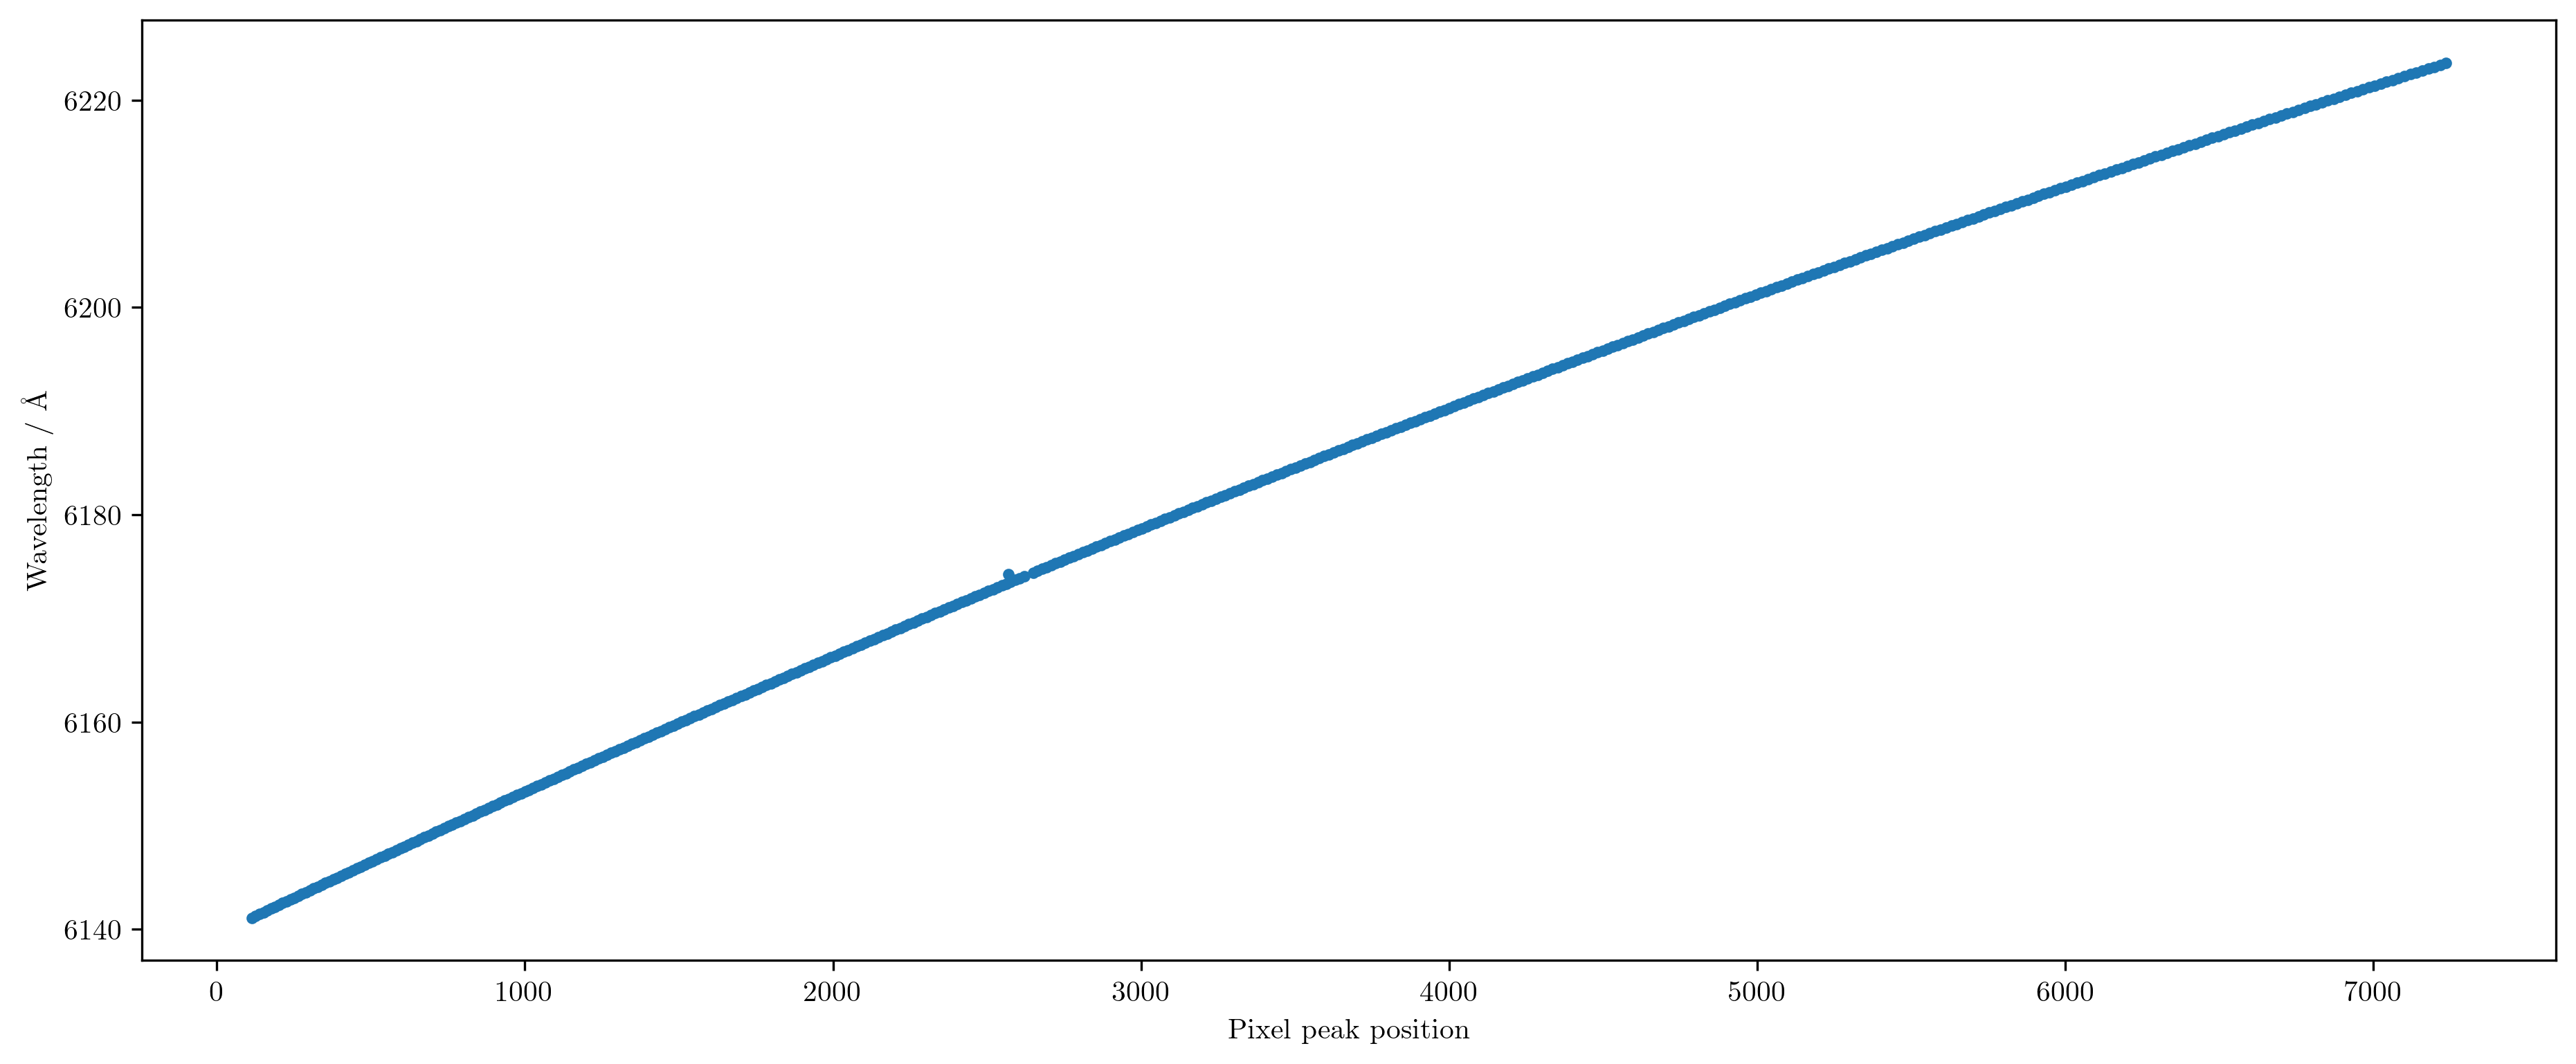

In [79]:
filename = r"expres_tp/LFC_200907.1063.fits"
hdu1 = fits.open(filename)

order = 61
data = hdu1[1].data.copy()
data_spec       = data['spectrum'][order]
data_spec_err   = data['uncertainty'][order]
data_wavel      = data['wavelength'][order]

# Find peaks
peak_info = func_find_peaks(data_spec, 11, 0.15)
peak_locs = peak_info[0]

# Create data slices around each peak
peak_index_ranges = get_peak_index_ranges(peak_locs)

# Fit peak in each data slice
peak_fits = fit_peaks(data_spec, data_spec_err, peak_index_ranges)

# Get list of true wavelengths
wavel_true = get_true_wavel(data_wavel, peak_locs)[:, 0] # second column is the n in the true wavel peak formula

# Plot
plt.figure(figsize=(15,6))
plt.plot(peak_fits[:,2], wavel_true, ".")
plt.xlabel("Pixel peak position")
plt.ylabel("Wavelength / Å")

In [81]:
peak_fits[:,0]

array([ 0.36384376,  0.36284292, -0.31384953,  0.40603166,  0.49992091,
       -0.46017295,  0.53204474,  0.56390867,  0.404608  ,  0.38572242,
        0.36966767,  0.39778264,  0.43638513,  0.48410919,  0.4629363 ,
        0.47256719,  0.48174604,  0.56623201,  0.48926666,  0.46712813,
        0.45464175,  0.10913946,  0.52892812,  0.56443619,  0.47801782,
        0.11861479,  0.4287271 ,  0.47015468,  0.37214416,  0.42890191,
        0.09422172,  0.40332055,  0.41634455,  0.45622324,  0.48430617,
        0.4564594 ,  0.47322985,  0.40702597,  0.41417073,  0.47577084,
        0.42886292,  0.45338699,  0.50701691,  0.54533119,  0.58315619,
        0.51522883,  0.4889758 ,  0.1001407 ,  0.47262048,  0.51585375,
        0.44277883,  0.11588826,  0.10947909,  0.55762786,  0.51022374,
        0.47917806,  0.49916963,  0.44983537,  0.40079475,  0.41232496,
        0.45042345,  0.43880029,  0.4908084 ,  0.52355453,  0.51186712,
        0.52078832,  0.51357526,  0.4553781 ,  0.53669956,  0.42

#### Analyze all orders

In [5]:
# Load data
results = fit_all_peaks_in_all_orders(correct_errors=True)

/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:70: RuntimeWarning: overflow encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)
/Users/jakobharteg/GitHub/bachelor-project/calibration_functions.py:70: RuntimeWarning: divide by zero encountered in power
  return A * np.exp(-z**P) + C + b * (x - mu)


#### Number of peaks per order

Text(0.5, 1.0, 'Number of peaks per order')

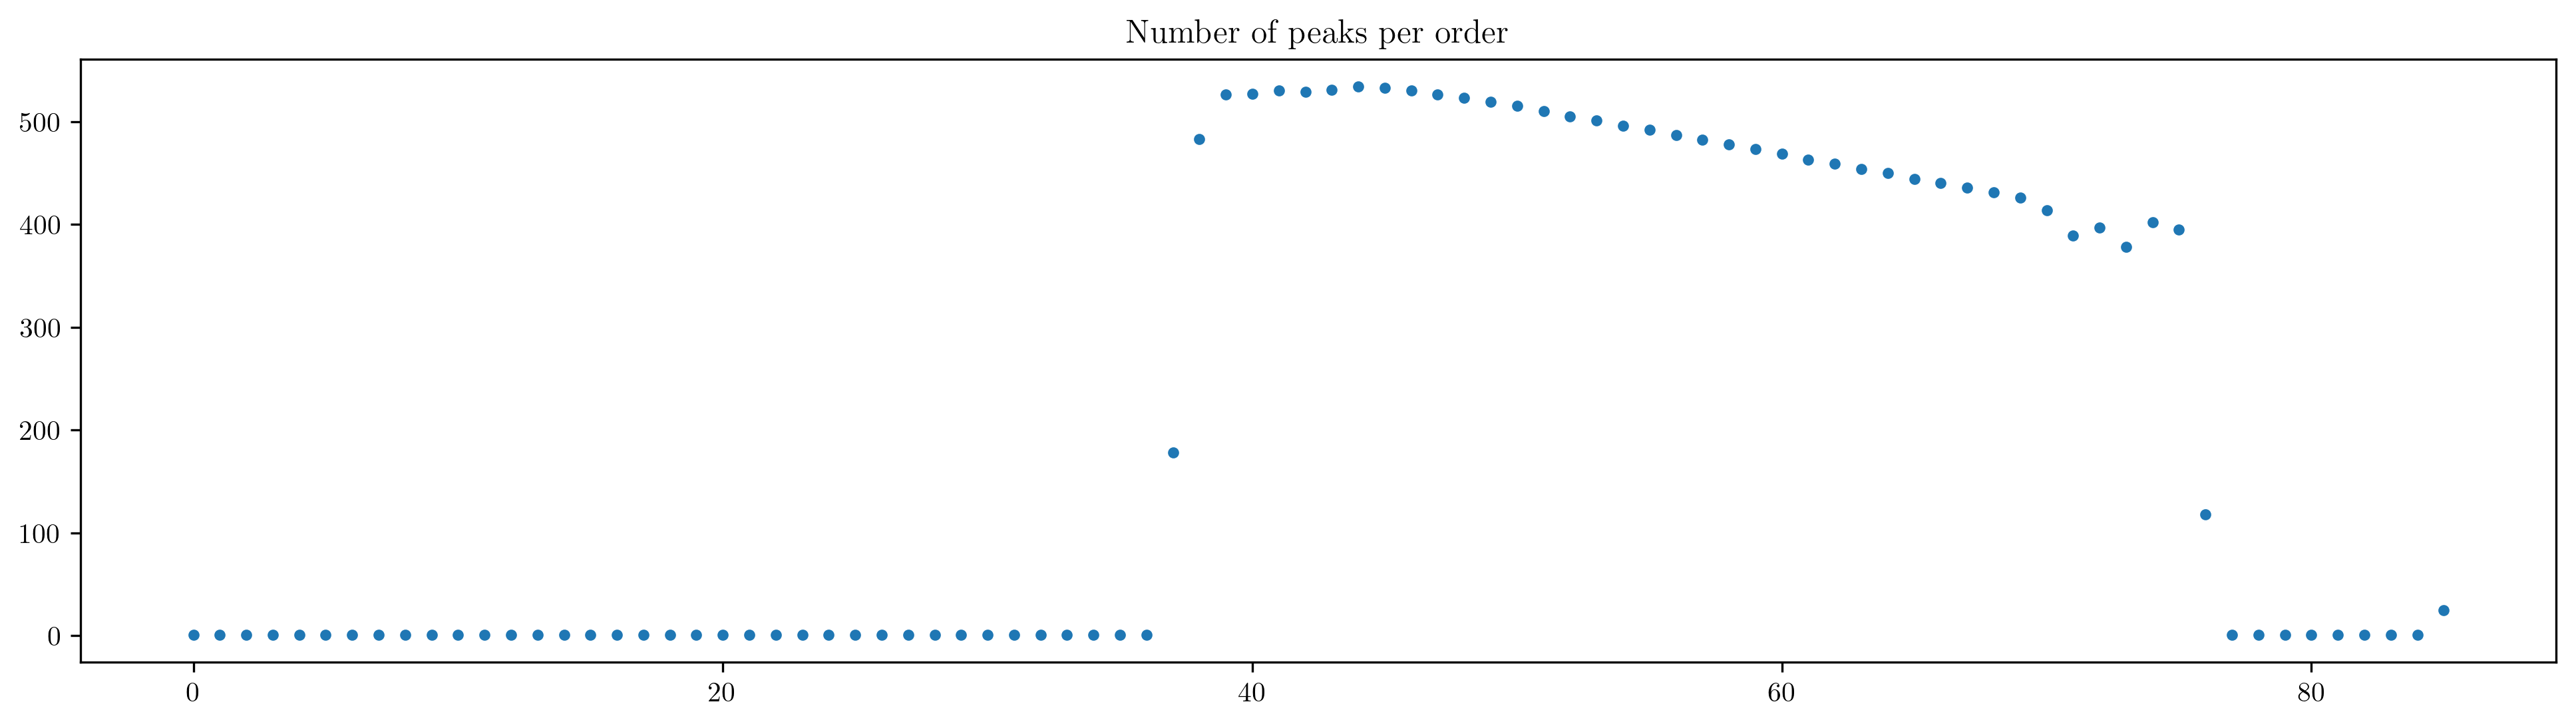

In [230]:
# Plot number of peaks per order
plt.figure(figsize=(16,4))
plt.plot(np.arange(len(results[:, 1])), [len(k) for k in results[:, 1]], ".")
plt.title("Number of peaks per order")

#### All calibration curves in one plot

Text(0.5, 1.0, 'Calibration curves (for orders 37-76)')

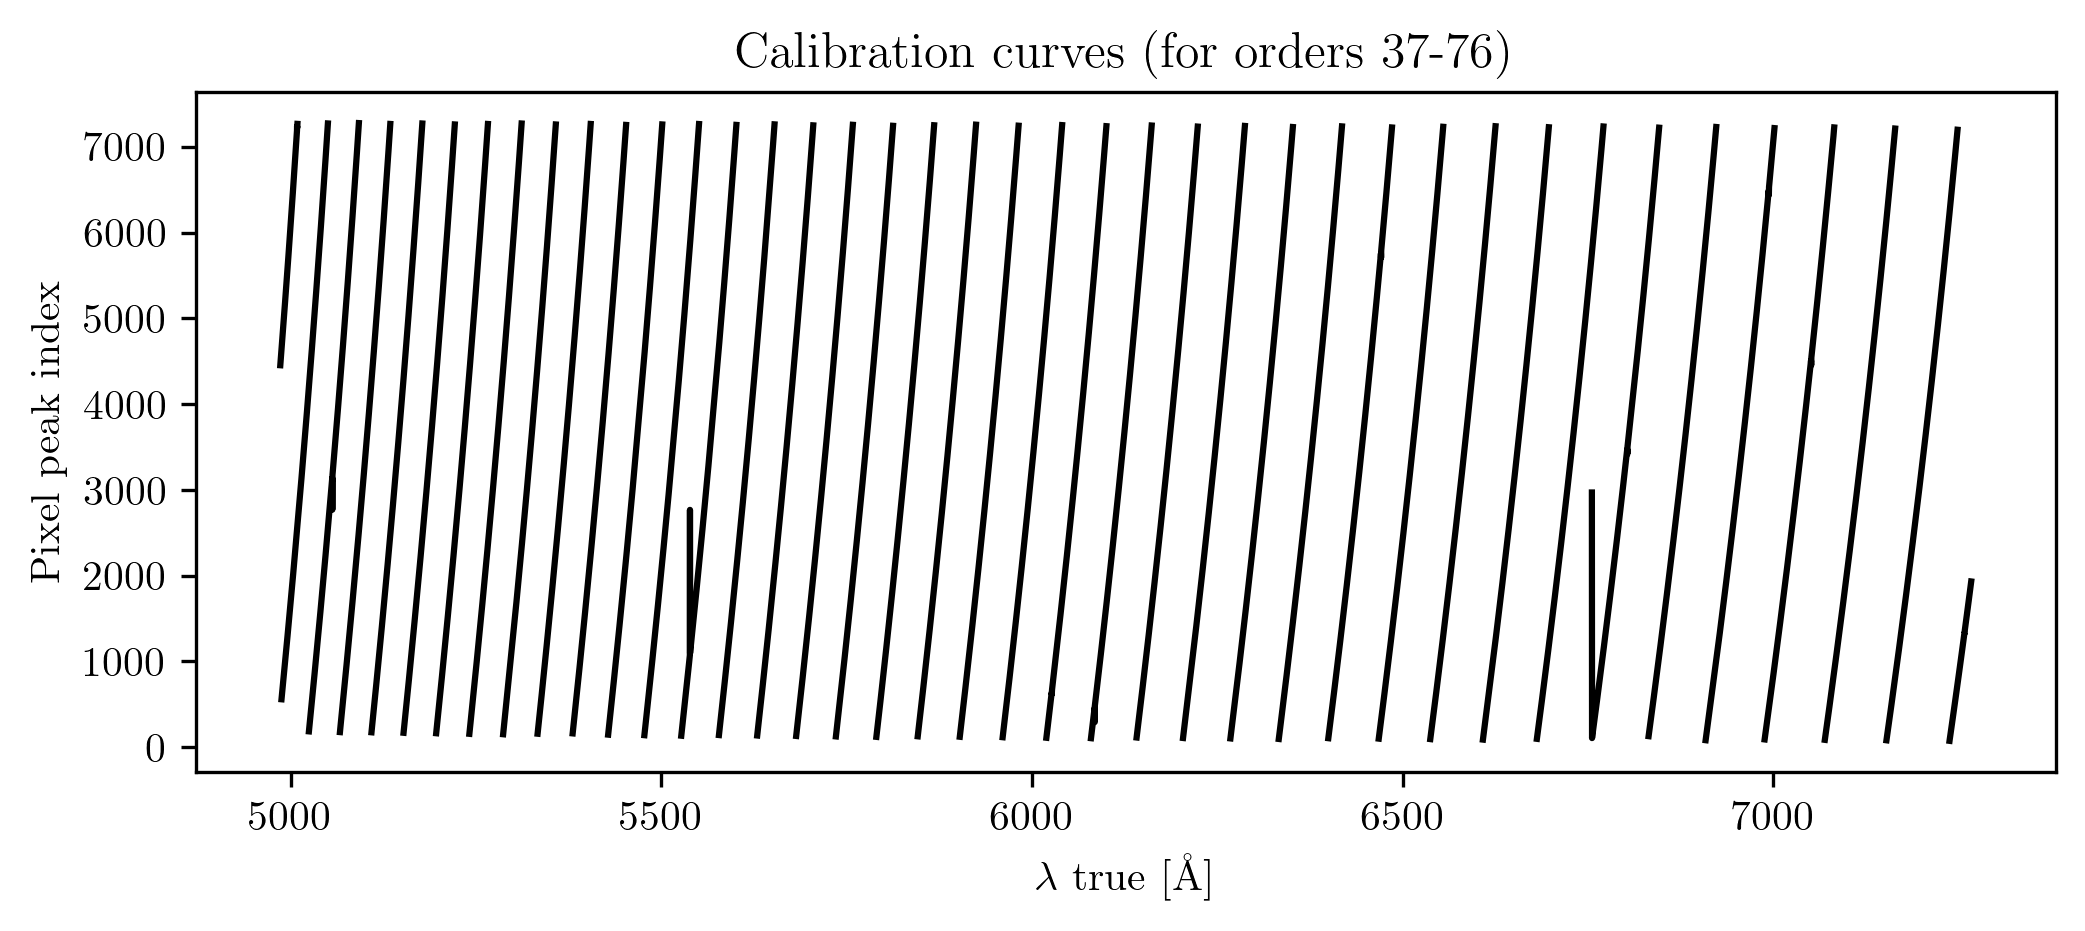

In [233]:
orders = results[:, 0]
peak_fits = results[:, 1]
wavel_true = results[:, 2]
wavel_given = results[:, 3]

plt.figure(figsize=(8,3))
for order in np.arange(37, 77):
    plt.plot(wavel_true[order][:, 0], peak_fits[order][:,2], "k")

plt.xlabel(f"$\lambda$ true [Å]")
plt.ylabel("Pixel peak index")
plt.title("Calibration curves (for orders 37-76)")
# plt.savefig("figures/calibration_curves.png", dpi=300)

#### Mean chi2 for each order

In [7]:
# TODO :: find way to compute mean chi2 for each order

# chi2_val_means = []
# for fit_vals in results[:, 1]:
#     print(fit_vals)
    # order_chi2 = []
    # for fit_val in fit_vals:
    #     if len(fit_val) > 1:
    #         order_chi2.append(fit_val[4])
    # chi2_val_means.append(np.mean(order_chi2))
    

    # if len(k) == 4:
    #     print(k)

# for res in results:
#     if res[]

#     if not np.isnan(peak_fit[0][0]):
#         chi2_vals = peak_fit[:, 4]
#         chi2_val_means.append(np.mean(chi2_vals))

# plt.figure(figsize=(16,8))
# plt.plot(np.arange(len(chi2_val_means)), chi2_val_means, ".")
# plt.title("Number of peaks per order")


### Save peak fits data to parquet file

In [17]:
orders = results[:, 0]
peak_fits = results[:, 1]
wavel_true = results[:, 2]
wavel_given = results[:, 3]

table = []

# Columns: peak_id, A, mu, sigma, P, c, b, ν_n, λ_true_peak, λ_approx_peak, x_min, x_max, χ², converged, valid, std_A, std_μ, std_σ, std_P, std_c, std_b, order

# for order in range(37, max(orders)):
for order in orders:
    for peak in range(len(peak_fits[order])):

        # Get fit values for peaks
        peak_fit =  peak_fits[order][peak]

        if(len(peak_fit) == 1):
            # no peak_fit
            # A, A_err, mu, mu_err, sigma, sigma_err, C, C_err, chi2_val, ndof, converged, pixmin, pixmax = [np.nan] * 13
            # lambd = np.nan
            # lambd_n = np.nan
            continue # skip to next order
        else: 
            A, A_err, mu, mu_err, sigma, sigma_err, C, C_err, chi2_val, ndof, converged, pixmin, pixmax, prop = peak_fit
            lambd = wavel_true[order][peak][0]
            lambd_n = wavel_true[order][peak][1]
    
        # Assemble row
        row = [
            A,
            mu,
            sigma, 
            np.nan,                         # P
            np.nan,                         # c
            np.nan,                         # b
            lambd_n,                        # ν_n
            lambd,                          # λ_true_peak
            wavel_given[order][peak],       # wavel_given
            pixmin,                         # xmin
            pixmax,                         # xmax
            chi2_val,                       # chi2
            converged,                      # converged
            np.nan,                         # valid
            A_err,                          # A err
            mu_err,                         # mu err
            sigma_err,                      # sigma err
            np.nan,                         # P err
            np.nan,                         # c err
            np.nan,                         # b err
            int(order)
         ]
        table.append(row)


columns = ["A", "μ", "σ", "P", "c", "b", "ν_n", "λ_true_peak", "λ_approx_peak", "x_min", "x_max", "χ²", "converged", "valid", "std_A", "std_μ", "std_σ", "std_P", "std_c", "std_b", "order"]
rows = np.asarray(table, dtype=object)
df = pd.DataFrame(rows, columns=columns)
# df.to_excel("data/fit_params.xlsx") 
# df.to_parquet('data/fit_params.parquet')

# Display DataFrame
pd.options.display.max_columns = None
pd.options.display.max_rows = 20
# pd.options.display.min_rows = 100
pd.set_option('display.expand_frame_repr', True)
df

,A,μ,σ,P,c,b,ν_n,λ_true_peak,λ_approx_peak,x_min,x_max,χ²,converged,valid,std_A,std_μ,std_σ,std_P,std_c,std_b,order
0,-0.144113,4454.086955,-1.413753,NaN,NaN,NaN,42947.0,4986.035473,4986.034499,4446.0,4461.0,80.829142,1.0,NaN,0.001193,0.01022,0.009042,NaN,NaN,NaN,37
1,-0.144579,4467.067706,1.423024,NaN,NaN,NaN,42946.0,4986.151572,4986.150572,4459.0,4474.0,120.210335,1.0,NaN,0.001194,0.010144,0.009041,NaN,NaN,NaN,37
2,0.155247,4584.610342,-1.819059,NaN,NaN,NaN,42937.0,4987.196706,4987.200095,4577.0,4592.0,21.599898,1.0,NaN,0.001537,0.011991,0.012392,NaN,NaN,NaN,37
3,0.004968,4610.684331,-0.000012,NaN,NaN,NaN,42935.0,4987.429017,4987.430363,4603.0,4618.0,19643.825093,1.0,NaN,0.000162,1.062927,0.135936,NaN,NaN,NaN,37
4,-0.162868,4637.102858,1.430415,NaN,NaN,NaN,42933.0,4987.66135,4987.660277,4629.0,4644.0,78.499646,1.0,NaN,0.001307,0.010139,0.009082,NaN,NaN,NaN,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18393,0.243012,4419.999968,39.61429,NaN,NaN,NaN,26184.0,8178.042092,8177.983023,4335.0,4505.0,137.983093,1.0,NaN,0.453959,0.003558,235.366542,NaN,NaN,NaN,85
18394,9.677522,4515.161128,62.507975,NaN,NaN,NaN,26180.0,8179.291581,8179.400554,4433.0,4603.0,130.622509,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,85
18395,-0.06708,4658.685392,97.668236,NaN,NaN,NaN,26176.0,8180.541451,8180.609115,4517.0,4687.0,132.540443,0.0,NaN,33336.70882,32.734535,22987.726609,NaN,NaN,NaN,85
18396,0.969099,4675.697781,-0.077214,NaN,NaN,NaN,26172.0,8181.791704,8181.668864,4591.0,4761.0,160.518224,1.0,NaN,5.38323,0.765598,0.09776,NaN,NaN,NaN,85


### Plot fit params to compare with Christian

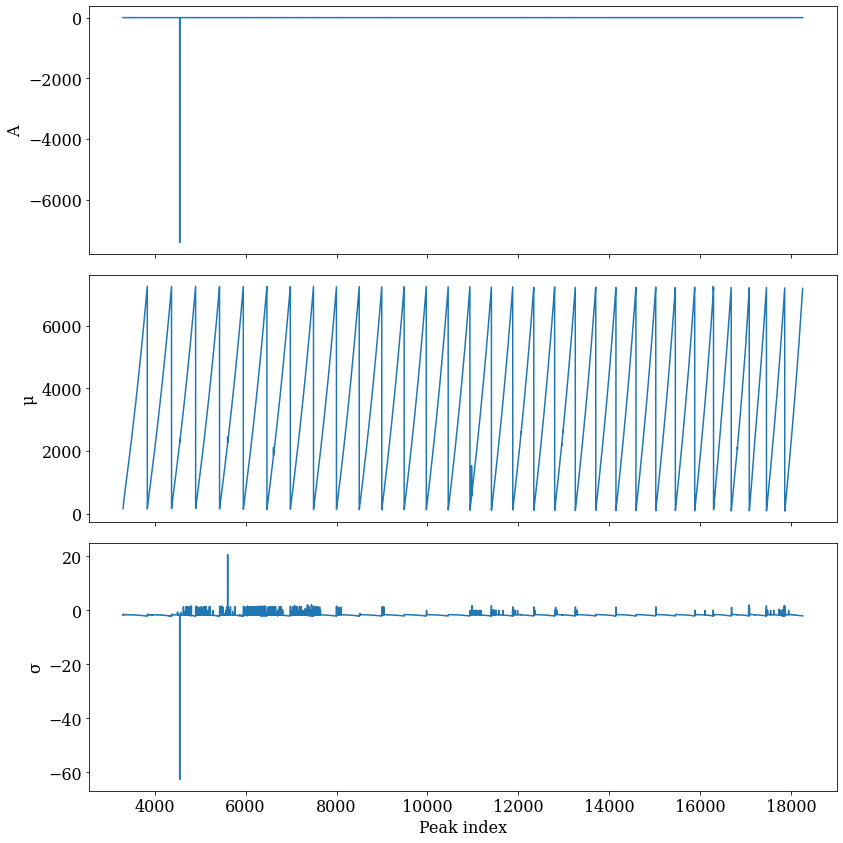

In [18]:
df_cropped = df[(df['order'] > 43) & (df['order'] < 76)]
fig, ax = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)

# A 
ax[0].plot(df_cropped["A"].index, df_cropped["A"].values)
ax[0].set_ylabel("A")

# mu
ax[1].plot(df_cropped["μ"].index, df_cropped["μ"].values)
ax[1].set_ylabel("μ")

# sigma
ax[2].plot(df_cropped["σ"].index, df_cropped["σ"].values)
ax[2].set_ylabel("σ")
ax[2].set_xlabel("Peak index")

# fig.savefig("figures/fit_params.png", dpi=300)
fig.tight_layout()

### Fit peak positions

In [10]:
results[0]

# order, peak_fits, wavel_true, wavel_given = result

# # Filter by chi2
# cols = ['A', "A_err", "mu", 'mu_err', 'sigma', 'sigma_err', 'c', 'c_err', "chi2", 'ndof', 'converged', 'index_start', 'index_end', 'p-value', 'P', 'P_err']
# peak_fits_df = pd.DataFrame(peak_fits, columns=cols)
# chi2_mask = (peak_fits_df.chi2 < 100)
# peak_fits = peak_fits[chi2_mask]
# wavel_true = wavel_true[chi2_mask]

array([0, list([[nan]]), list([[nan]]), list([nan])], dtype=object)

In [71]:
def compute_rms(x):
    x = x - np.mean(x)
    return np.sqrt(np.sum(x ** 2) / len(x - 1))


def compute_residuals_for_poly_fit(results, degree, ax=None, plot=True, plot_order=None, max_chi2=100):
    peak_pos_residuals = []
    peak_pos_chi2 = []
    peak_pos_valid = []
    for o in np.arange(40, 76):
        order, peak_fits, wavel_true, wavel_given = results[o]
        
        # Filter by chi2
        cols = ['A', "A_err", "mu", 'mu_err', 'sigma', 'sigma_err', 'c', 'c_err', "chi2", 'ndof', 'converged', 'index_start', 'index_end', 'p-value', 'P', 'P_err']
        peak_fits_df = pd.DataFrame(peak_fits, columns=cols)
        chi2_mask = (peak_fits_df.chi2 < max_chi2)
        peak_fits = peak_fits[chi2_mask]
        wavel_true = wavel_true[chi2_mask]

        # skip all other orders expect 44 for plotting
        if plot_order is not None:
            if order != plot_order:
                continue

        # Some requirements
        if np.isnan(peak_fits).all(): # leave out orders with no peaks 
            continue

        if order < 30:
            continue

        if len(peak_fits) < 30:
            continue
        
        # Fit peak positions
        fit_vals, chi2val, pval, fit_func, fit_valid = fit_peak_positions(wavel_true[:, 0], peak_fits, degree)

        # Compute fit residual
        x = peak_fits[:,2]
        c = 299792458 # m/s
        y_predicted = fit_func(x, *fit_vals)
        y_theory = wavel_true[:, 0] 
        residual = (y_predicted - y_theory)/y_theory * c
        peak_pos_residuals.append(residual)
        peak_pos_chi2.append(chi2val)
        peak_pos_valid.append(pval != 0)
        
        # Plot all orders
        if plot:
            if ax is None:
                fig, ax = plt.subplots(figsize=(6,2))
            ax.scatter(x[10:-10], residual[10:-10], s=0.1, color="C0")
            text = f"{degree}. degree \n $\chi^2$ = {chi2val:.3} \n p = {pval:.3} \n rms = {compute_rms(residual[10:-10]):.3} m/s"
            ax.text(0.1, 0.82, text, fontsize=7, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            ax.set_ylim(min(residual[10:-10]), max(residual[10:-10]) * 1.5)
            # ax.set_title(f"{order}. order (chi2 = {chi2val:.3})")
            # ax.set_ylabel("$\lambda_{fit} - \lambda_{true}$ [Å]")


    if size(peak_pos_residuals) == 0:
        return np.nan, np.nan, np.nan

    peak_pos_residuals = np.asarray(peak_pos_residuals, dtype=object)
    peak_pos_residuals = np.concatenate(peak_pos_residuals) # flatten array
    peak_pos_chi2 = np.asarray(peak_pos_chi2)

    return peak_pos_residuals, peak_pos_chi2, peak_pos_valid

In [195]:
# for degree in [1,2,3,4,5,6]:
#     peak_pos_residuals, peak_pos_chi2, peak_pos_valid = compute_residuals_for_poly_fit(results, degree, plot=False)
#     plt.figure(figsize=(6,2))
#     plt.title(f"{degree}. degrees")
#     plt.plot(peak_pos_chi2[peak_pos_valid], ".", label=f"chi2 mean = {np.mean(peak_pos_chi2):.3}");
#     plt.legend()


# # plt.figure(figsize=(8,4))
# # plt.hist(peak_pos_residuals, bins=1000, range=(-10e-3, 10e-3));


### Plot for report 

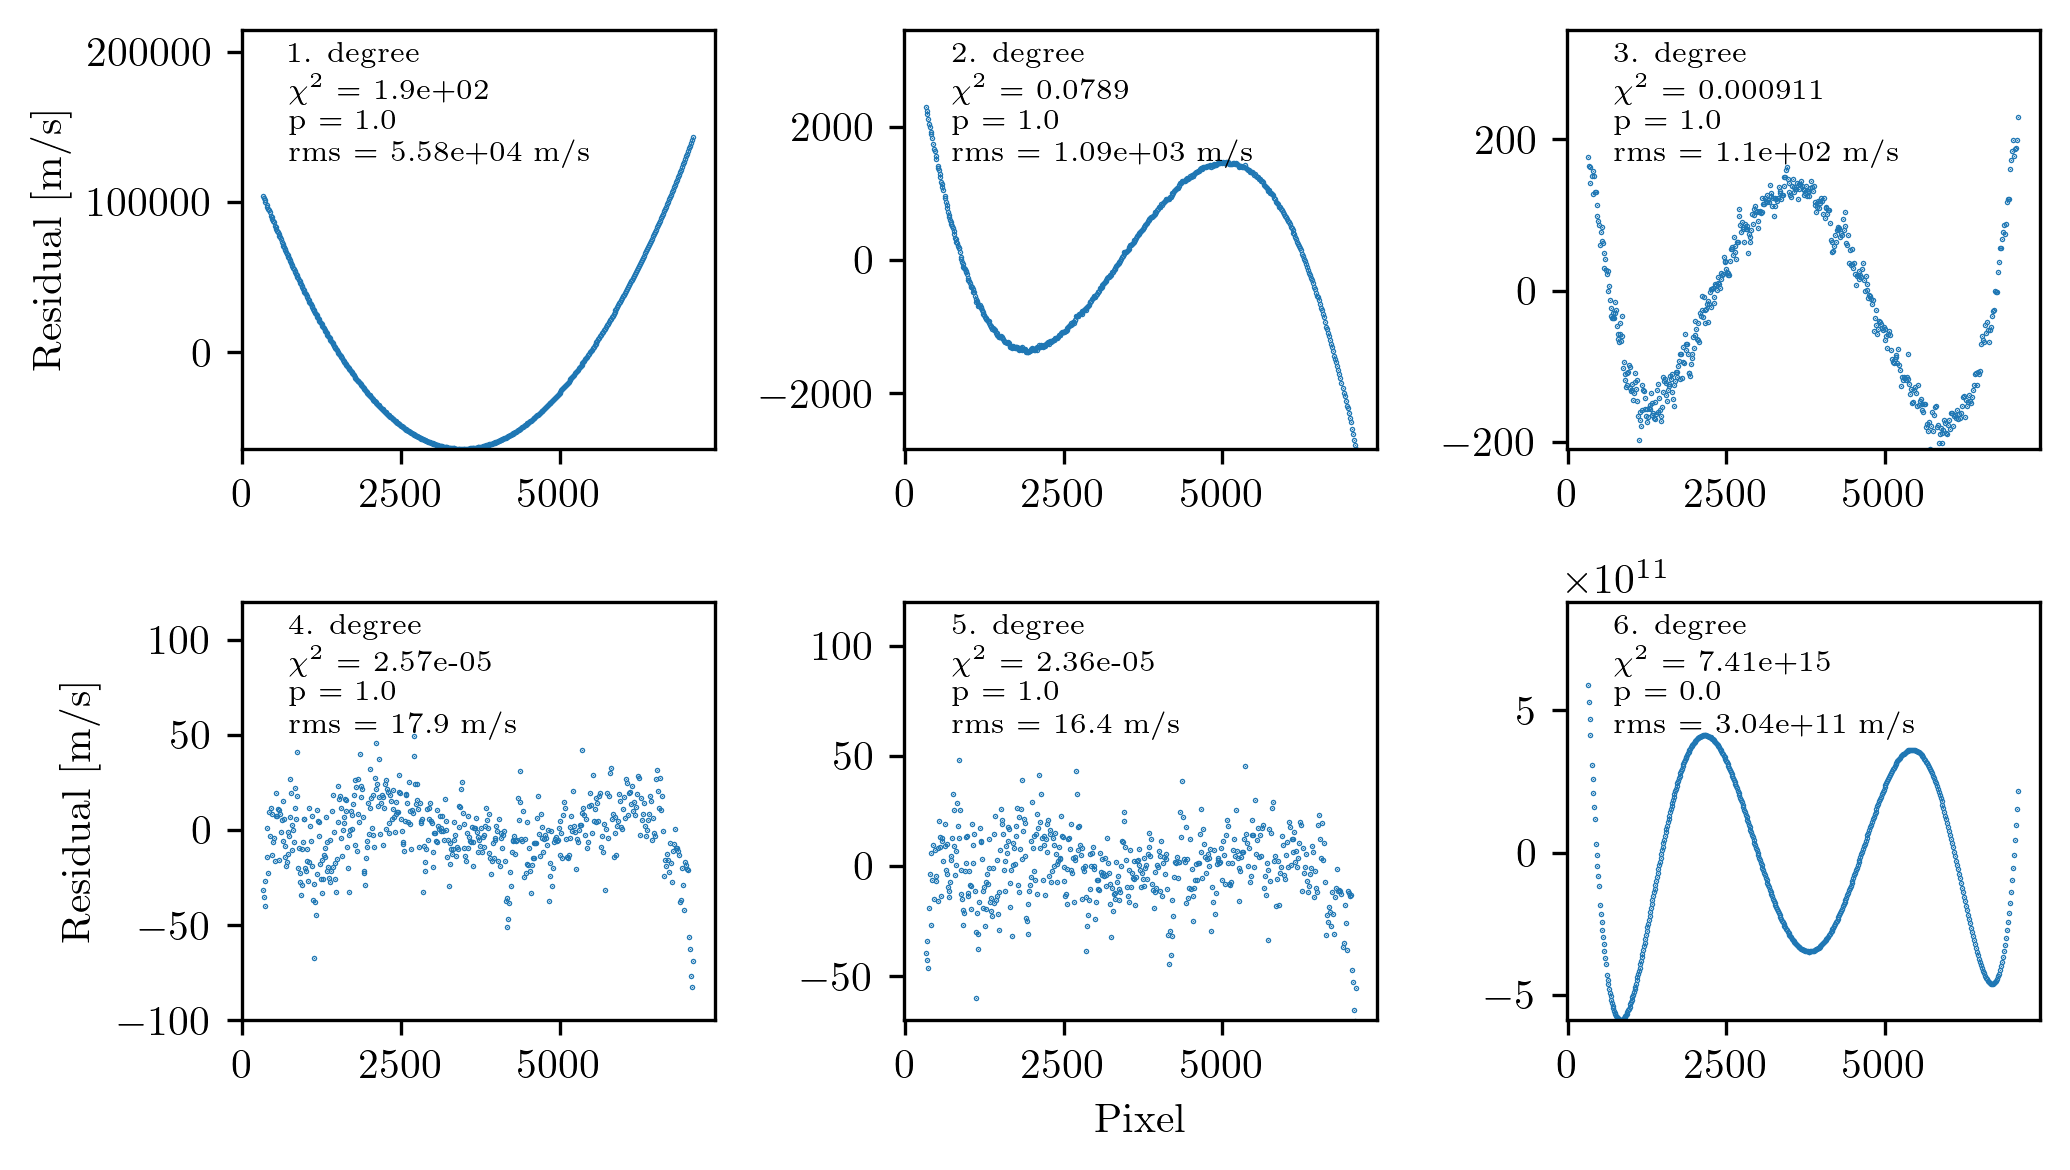

In [78]:
# for o in [37, 44, 48, 55, 65]:
o = 44
fig, all_axs = plt.subplots(ncols=3, nrows=2, figsize=(7,4))
axs = all_axs.flatten()
for index, ax in enumerate(axs):
    _ = compute_residuals_for_poly_fit(results, index + 1, ax, plot_order=o)

axs[0].set_ylabel("Residual [m/s]")
axs[3].set_ylabel("Residual [m/s]")
axs[4].set_xlabel("Pixel")
axs[3].set_ylim(-100, 120)
axs[4].set_ylim(-70, 120)

fig.tight_layout()

# fig.savefig("latex/figures/calib/calib_poly_fit_degrees_order44_residuals_ang.pdf", bbox_inches="tight", dpi=300)

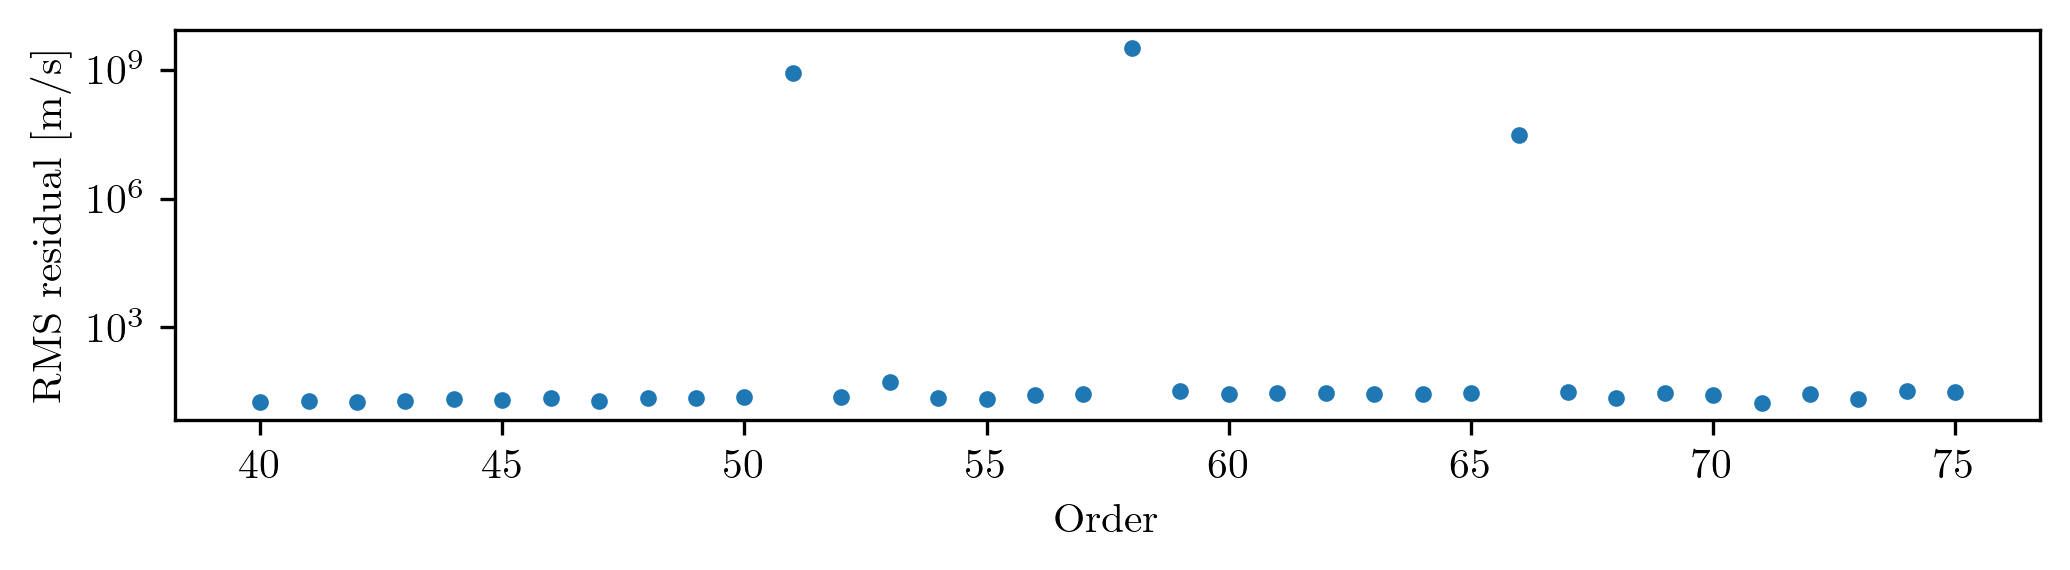

In [69]:
# See residuals RMS for poly degree 5 as a function of orders
def plot_res_for_degree(results, degree):
    orders = np.arange(37, 78)
    res = []
    for o in orders:
        peak_pos_residuals, peak_pos_chi2, peak_pos_valid = compute_residuals_for_poly_fit(results, degree, plot=False, plot_order=o)
        if peak_pos_residuals is np.nan:
            res.append(np.nan)
        else:
            res.append(compute_rms(peak_pos_residuals))

    ax2.plot(orders, res, ".", label=f"{degree}. degree poly")


fig, ax2 = plt.subplots(figsize=(7,2))
plot_res_for_degree(results, 5)
ax2.set_yscale("log")
ax2.set_xlabel("Order")
ax2.set_ylabel("RMS residual [m/s]")
# ax2.legend(loc="upper right")
fig.tight_layout()

# fig.savefig("latex/figures/calib/calib_poly_5th_res.pdf", bbox_inches="tight", dpi=300)

#### Compute RMS across all orders

In [55]:
# See residuals RMS for poly degree 5 as a function of orders
def compute_residuals_for_all_orders(results, degree=5, max_chi2=100):
    orders = np.arange(40, 76)
    res = []
    for o in orders:
        peak_pos_residuals, peak_pos_chi2, peak_pos_valid = compute_residuals_for_poly_fit(results, degree, plot=False, plot_order=o, max_chi2=max_chi2)
        res.append(peak_pos_residuals)
    res = np.hstack(res)
    return res

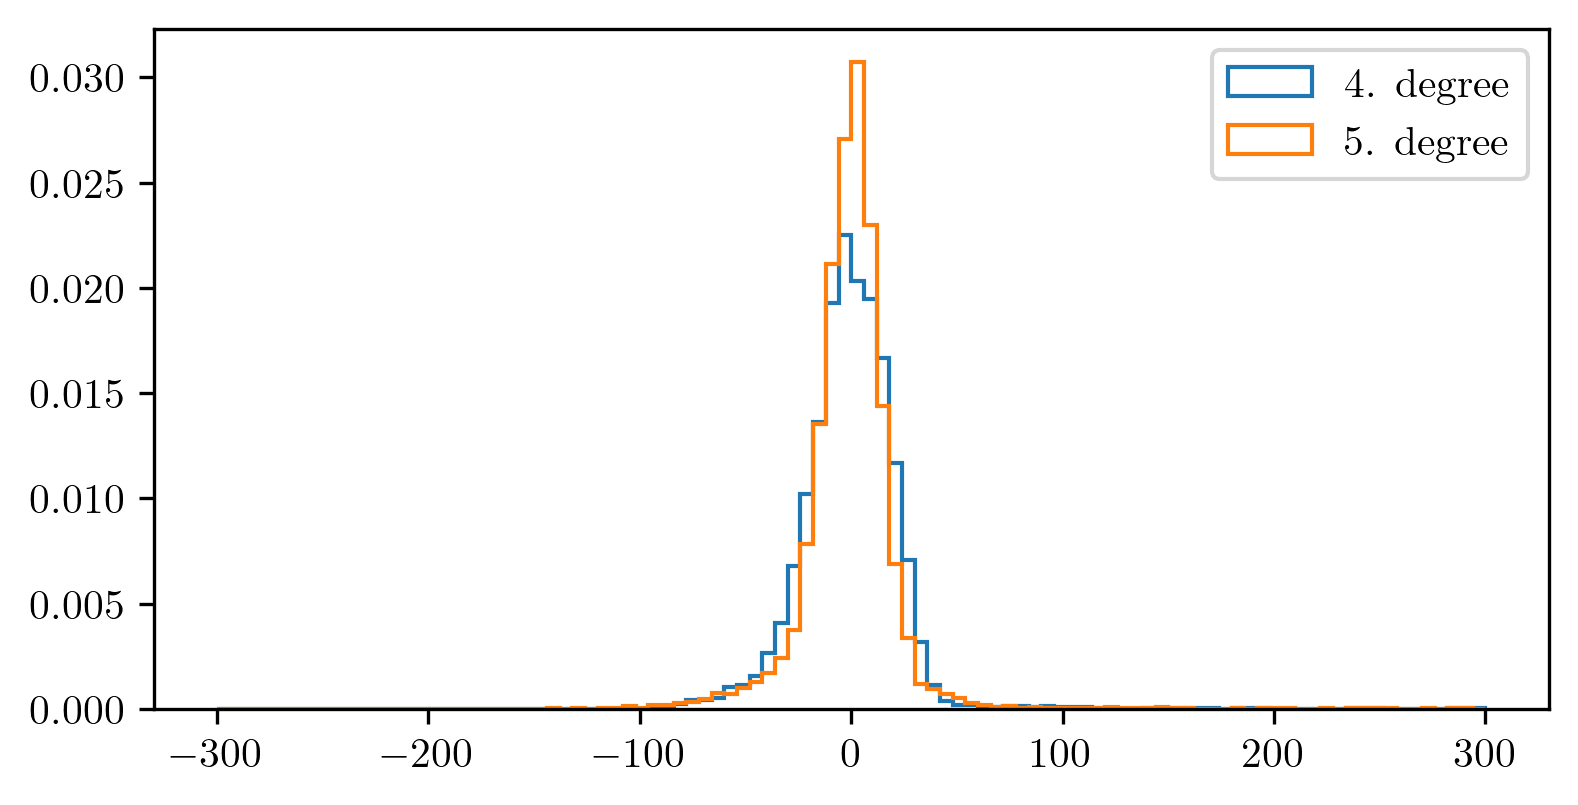

In [52]:
fig, ax = plt.subplots(figsize=(6,3))
# for degree in [3, 4, 5, 6, 7, 8, 9]:
for degree in [4, 5]:
    res = compute_residuals_for_all_orders(results, degree=degree)
    ax.hist(res, range=(-300, 300), bins=100, density=True, histtype="step", label=f"{degree}. degree")
    # ax.scatter(degree, compute_rms(res), label=f"{degree}. degree")

ax.legend(loc="upper right")

chi2 = 2000 --> rms = 2.84e+09
chi2 = 1000 --> rms = 2.84e+09
chi2 = 500 --> rms = 2.84e+09
chi2 = 200 --> rms = 2.9e+09
chi2 = 100 --> rms = 5.73e+08
chi2 = 75 --> rms = 2.8e+09
chi2 = 50 --> rms = 3.53e+09
chi2 = 25 --> rms = 9.22e+08
chi2 = 15 --> rms = 6.47e+09


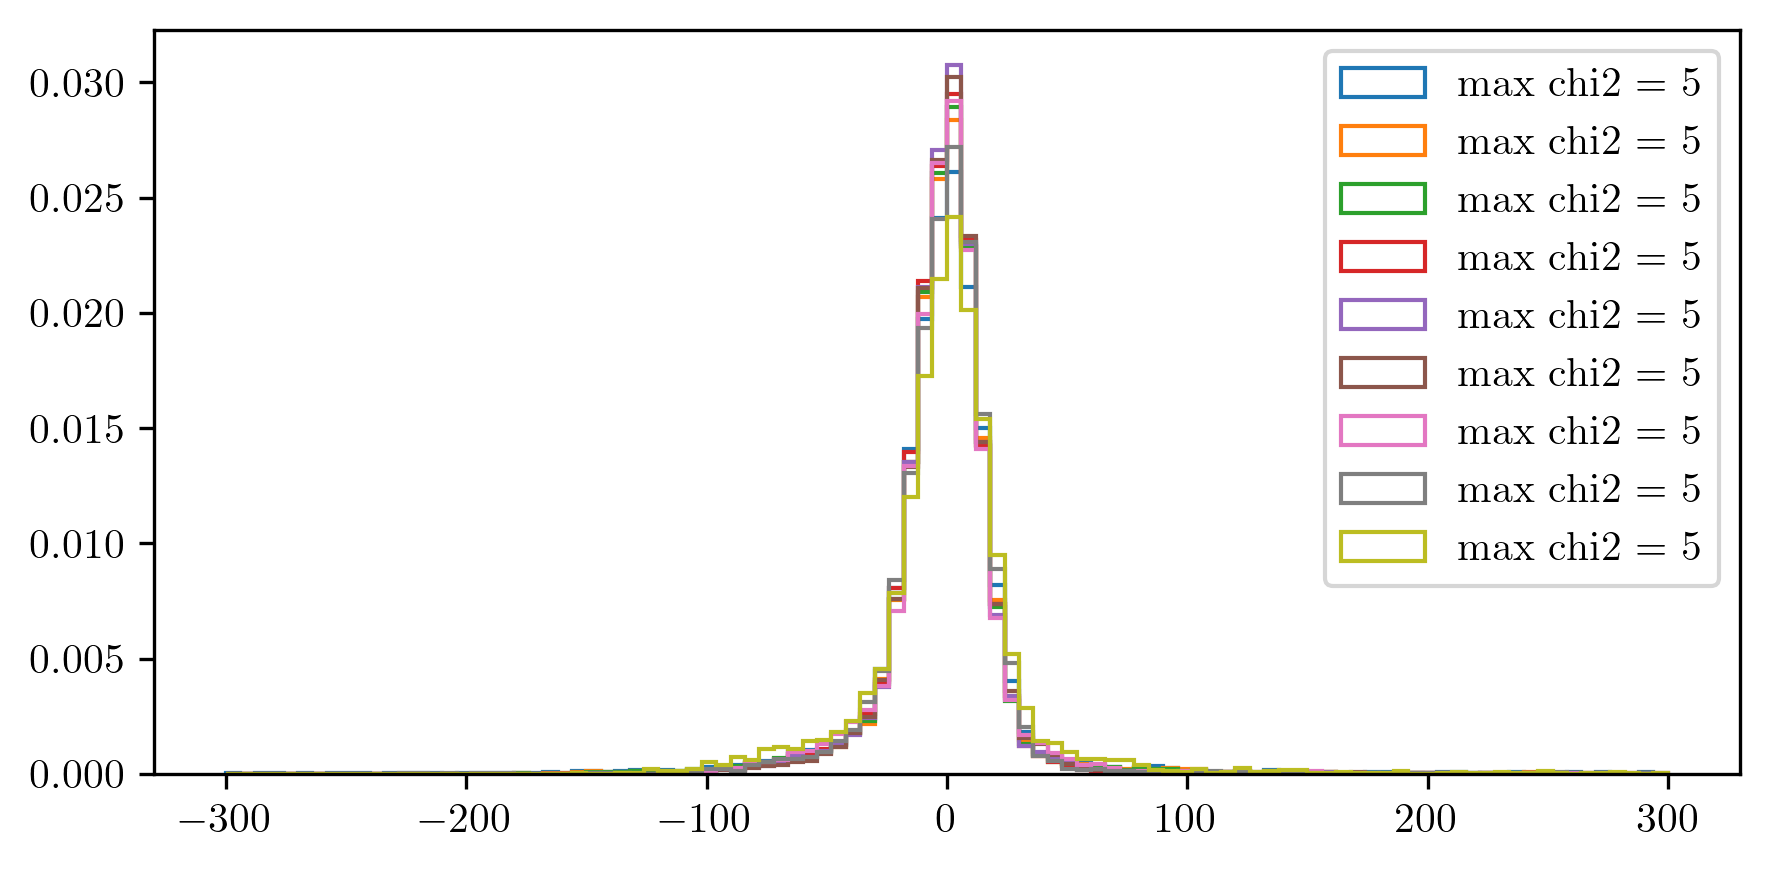

In [65]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6,3))
for chi2 in [2000, 1000, 500, 200, 100, 75, 50, 25, 15]:
    res = compute_residuals_for_all_orders(results, degree=5, max_chi2=chi2)
    ax1.hist(res, range=(-300, 300), bins=100, density=True, histtype="step", label=f"max chi2 = {degree}")
    # ax2.plot(chi2, compute_rms(res), ".", label=f"max chi2 = {chi2}")
    print(f"chi2 = {chi2} --> rms = {compute_rms(res):.3}")

fig.tight_layout()
ax1.legend()
ax2.legend()

### Save residuals for degree 5

In [53]:
res = compute_residuals_for_all_orders(results, degree=5)
# np.savetxt("fit_results/residuals_5degree_sqrt3_ms_chi2sorted.csv", res, delimiter=",")

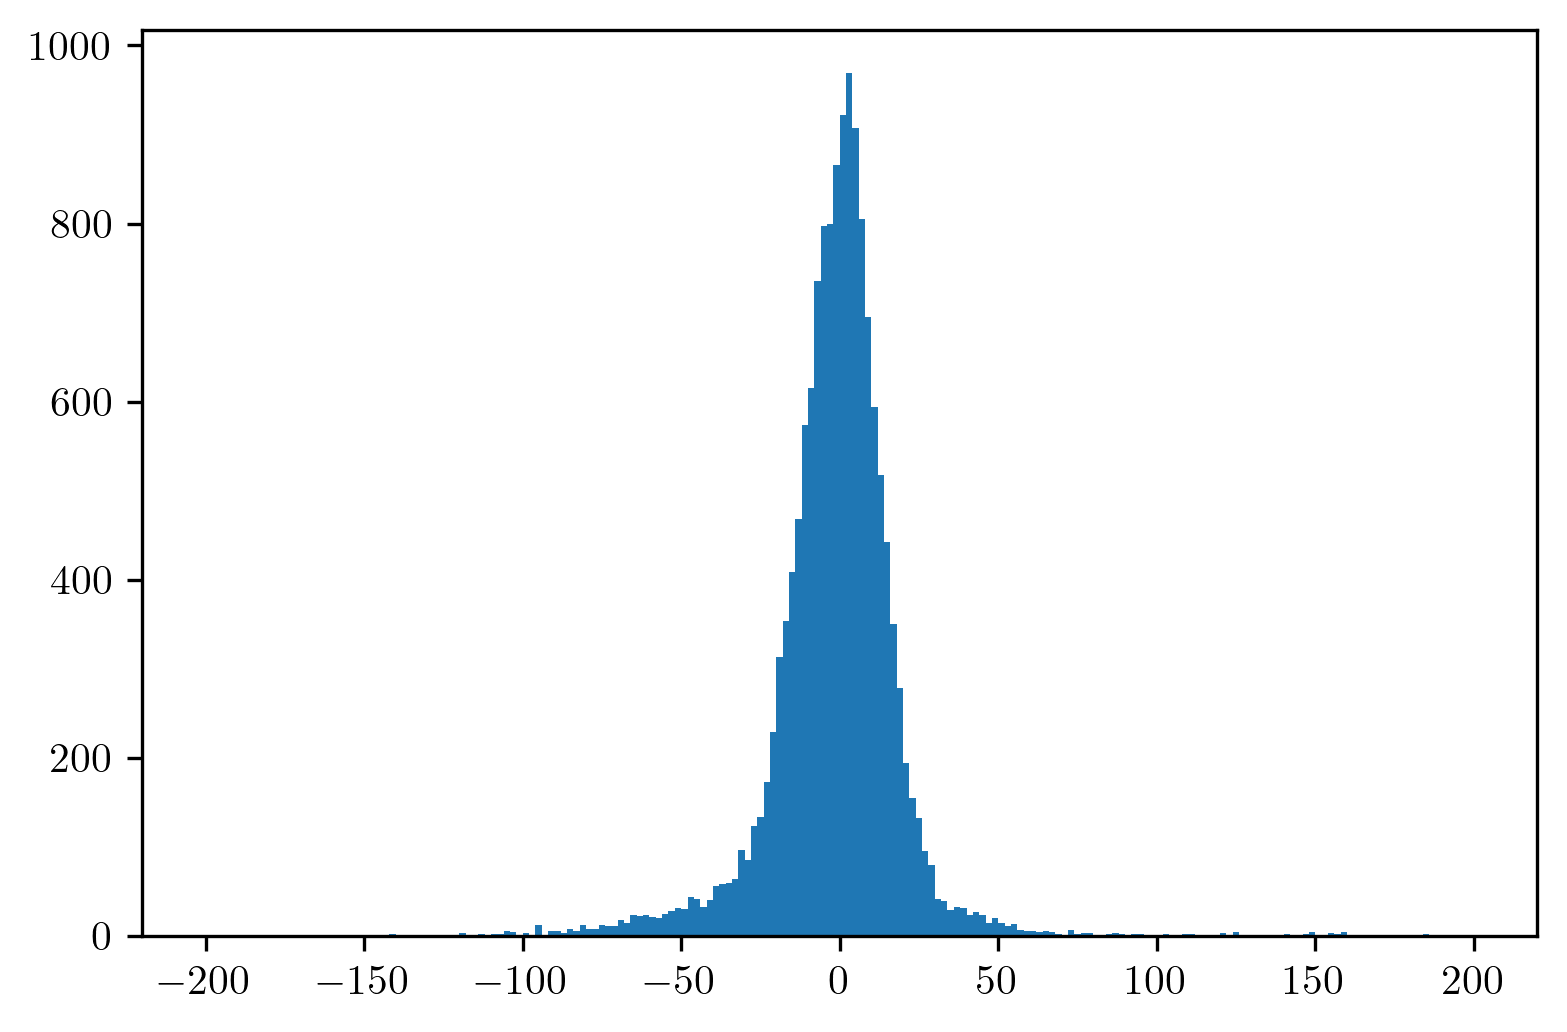

In [28]:
plt.hist(res, bins=200, range=(-200, 200));